# Predicting Heart Disease -- ADSP 31017 Final Project

Final Project Group: Alvin Yao, Amy (Hyunji) Kim, Samuel Martinez Koss, Zhiwei Guo

Data from: https://archive.ics.uci.edu/dataset/45/heart+disease, https://github.com/uci-ml-repo/ucimlrepo

## Setup

### Initialization

Connect to Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change base directory to standardize directory access.

In [2]:
import os

base_dir_alvin = '/content/drive/MyDrive/Academics/2 - Winter 2025/31017 - Machine Learning I/31017 Machine Learning I Team 6'
base_dir_amy = '/content/drive/MyDrive/31017 Machine Learning I Team 6'
base_dir_sam = '/content/drive/MyDrive/[96] MS-ADS/ADSP 31017 -- Machine Learning I/31017 Machine Learning I Team 6'
base_dir_wei = '/content/drive/MyDrive/31017 Machine Learning I Team 6'

base_dir = base_dir_sam
os.chdir(base_dir)
!pwd

/content/drive/.shortcut-targets-by-id/1vQDJzPot2_B3SvJ0D4mU1Zcac0TAW8oJ/31017 Machine Learning I Team 6


Import basic libraries.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.4f}'.format
pd.options.mode.chained_assignment = None  # default='warn'

### Data Loading

Upload from UC Irvine Machine Learning Repository.

In [4]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo, list_available_datasets

heart_disease = fetch_ucirepo(id=45)
df0 = heart_disease.data.original
df0.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3000,3,0.0000,6.0000,0
1,67,1,4,160,286,0,2,108,1,1.5000,2,3.0000,3.0000,2
2,67,1,4,120,229,0,2,129,1,2.6000,2,2.0000,7.0000,1
3,37,1,3,130,250,0,0,187,0,3.5000,3,0.0000,3.0000,0
4,41,0,2,130,204,0,2,172,0,1.4000,1,0.0000,3.0000,0


Identify feature data types.

In [5]:
cat_names = []
int_names = []

for i in np.arange(0,13):
    if heart_disease.variables.type[i] == 'Categorical':
        cat_names.append(heart_disease.data.features.columns[i])
    else:
        int_names.append(heart_disease.data.features.columns[i])

tar_name = heart_disease.data.targets.columns[0]

Filter missing data.

In [6]:
df = df0.dropna()

Simplify target variable to indicate presence of heart disease.

In [7]:
df[tar_name] = df[tar_name].replace({2:1, 3:1, 4:1})

### EDA

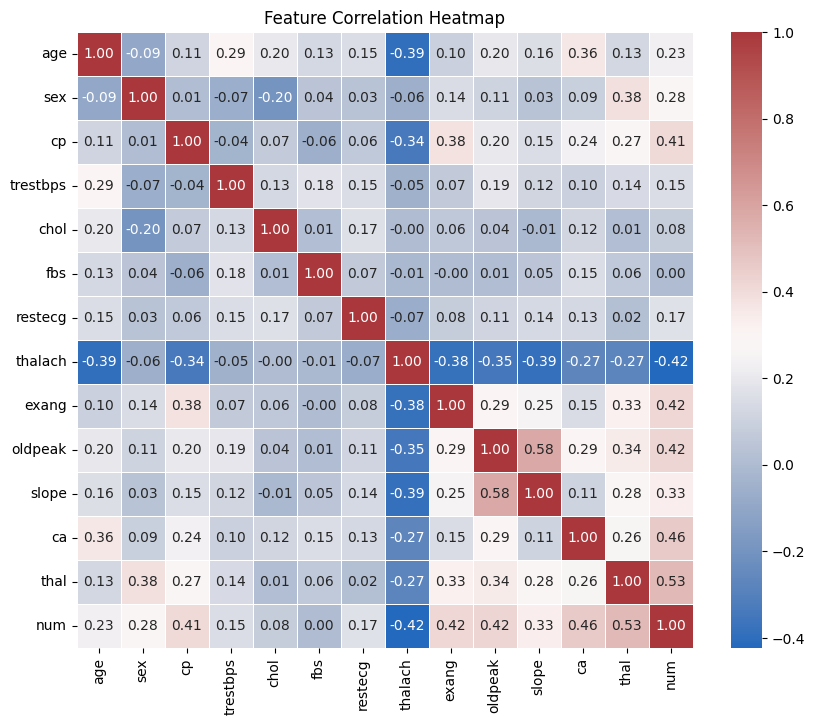

In [8]:
import seaborn as sns

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f",
            cmap='vlag', square=True, linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

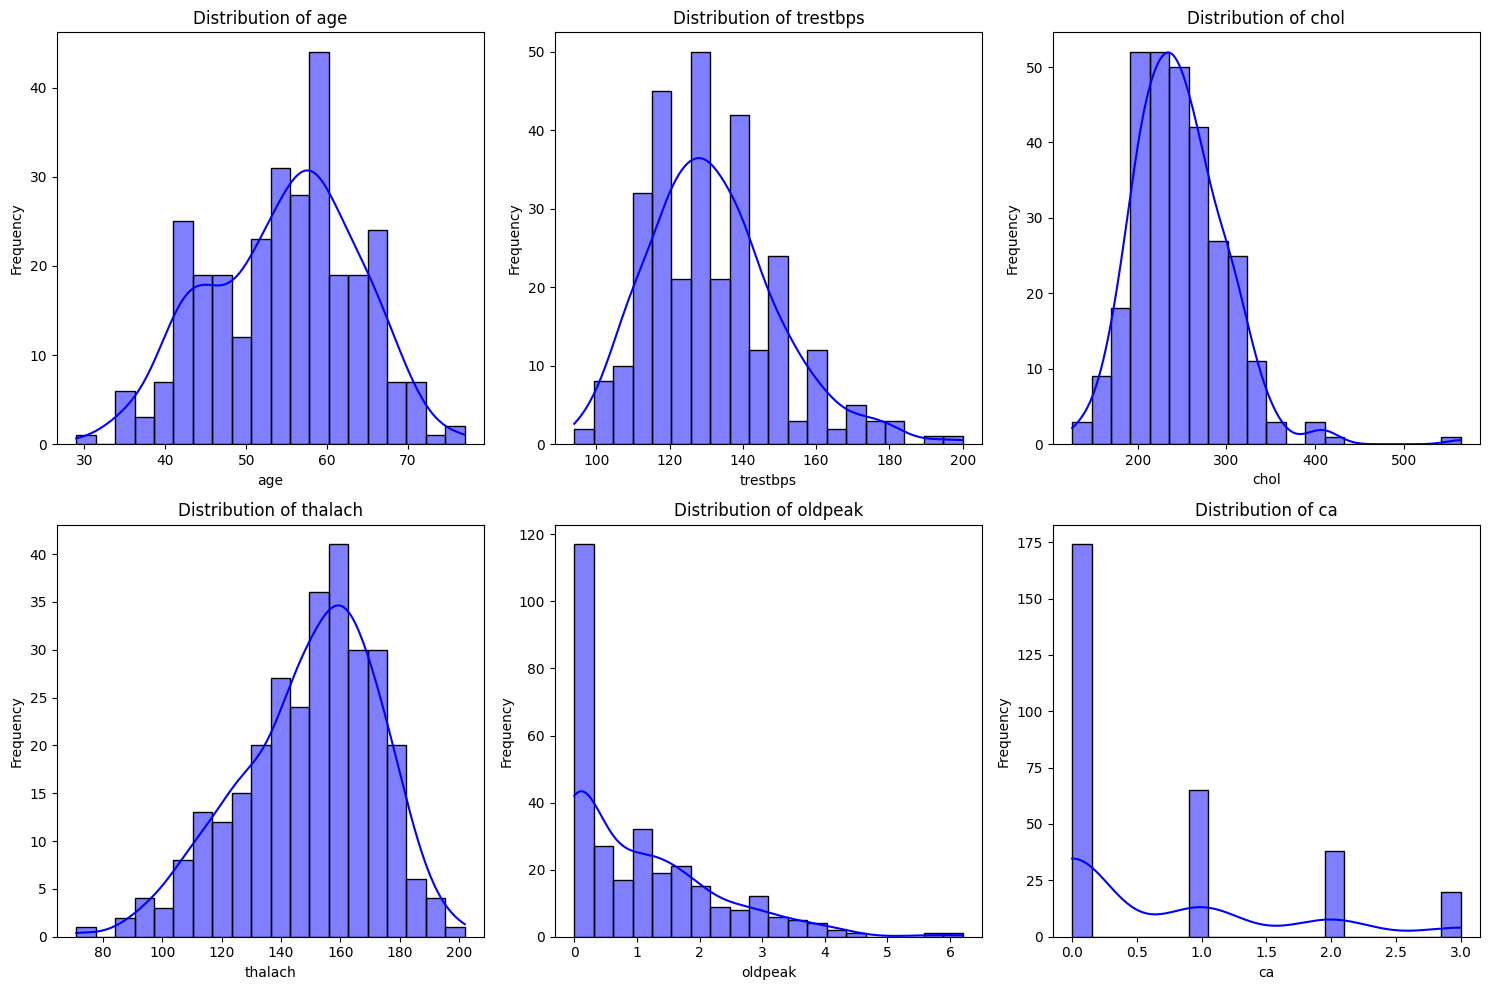

In [9]:
num_features = len(int_names)
rows = (num_features // 3) + (num_features % 3 > 0)  # Arrange in rows of 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

axes = axes.flatten()  # Flatten in case of a single row
for i, feature in enumerate(int_names):
    sns.histplot(df[feature], bins=20, kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
int_names.remove('ca')
cat_names.append('ca')

### Data Preprocessing

Split data for hold-out validation.

In [11]:
from sklearn.model_selection import train_test_split

Train, Test = train_test_split(df, test_size=0.3, random_state=17)

Rescale interval features by Train data.

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Train[int_names] = scaler.fit_transform(Train[int_names])
Test[int_names] = scaler.transform(Test[int_names])

Reorder and dummy code categorical features by frequency.

In [13]:
dum_names = []

for cat in cat_names:
    category_counts = Train[cat].value_counts()
    sorted_categories = category_counts.index

    Train[cat] = pd.Categorical(Train[cat], sorted_categories, True)
    Test[cat] = pd.Categorical(Test[cat], sorted_categories, True)

    Train_dummies = pd.get_dummies(Train[cat]).astype(int)
    Test_dummies = pd.get_dummies(Test[cat]).astype(int)

    Train_dummies.columns = [f"{cat}_{col}" for col in Train_dummies.columns]
    Test_dummies.columns = [f"{cat}_{col}" for col in Test_dummies.columns]

    Train = Train.join(Train_dummies)
    Test = Test.join(Test_dummies)

    dum_names.extend(Train_dummies.columns)

Define X and y. Select feature types from **int_names**, **cat_names**, and/or **dum_names** depending on model specifications.

In [14]:
X_train = Train[int_names + cat_names + dum_names]
y_train = Train[tar_name]

X_test = Test[int_names + cat_names + dum_names]
y_test = Test[tar_name]

## Feature Selection

### Classification Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image

In [16]:
param_grid = {
    "max_depth":[3,4,5,],
    "criterion": ('gini', 'entropy'),
    "splitter": ('best', 'random')
}

tree = DecisionTreeClassifier(random_state=17)
tree_CV = GridSearchCV(tree, param_grid, verbose=1, cv=10)
results=tree_CV.fit(X_train[int_names + dum_names], y_train)

print("The best parameter values are \n", results.best_params_)
print("Score:", tree_CV.score(X_train[int_names + dum_names], y_train))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
The best parameter values are 
 {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'random'}
Score: 0.8599033816425121


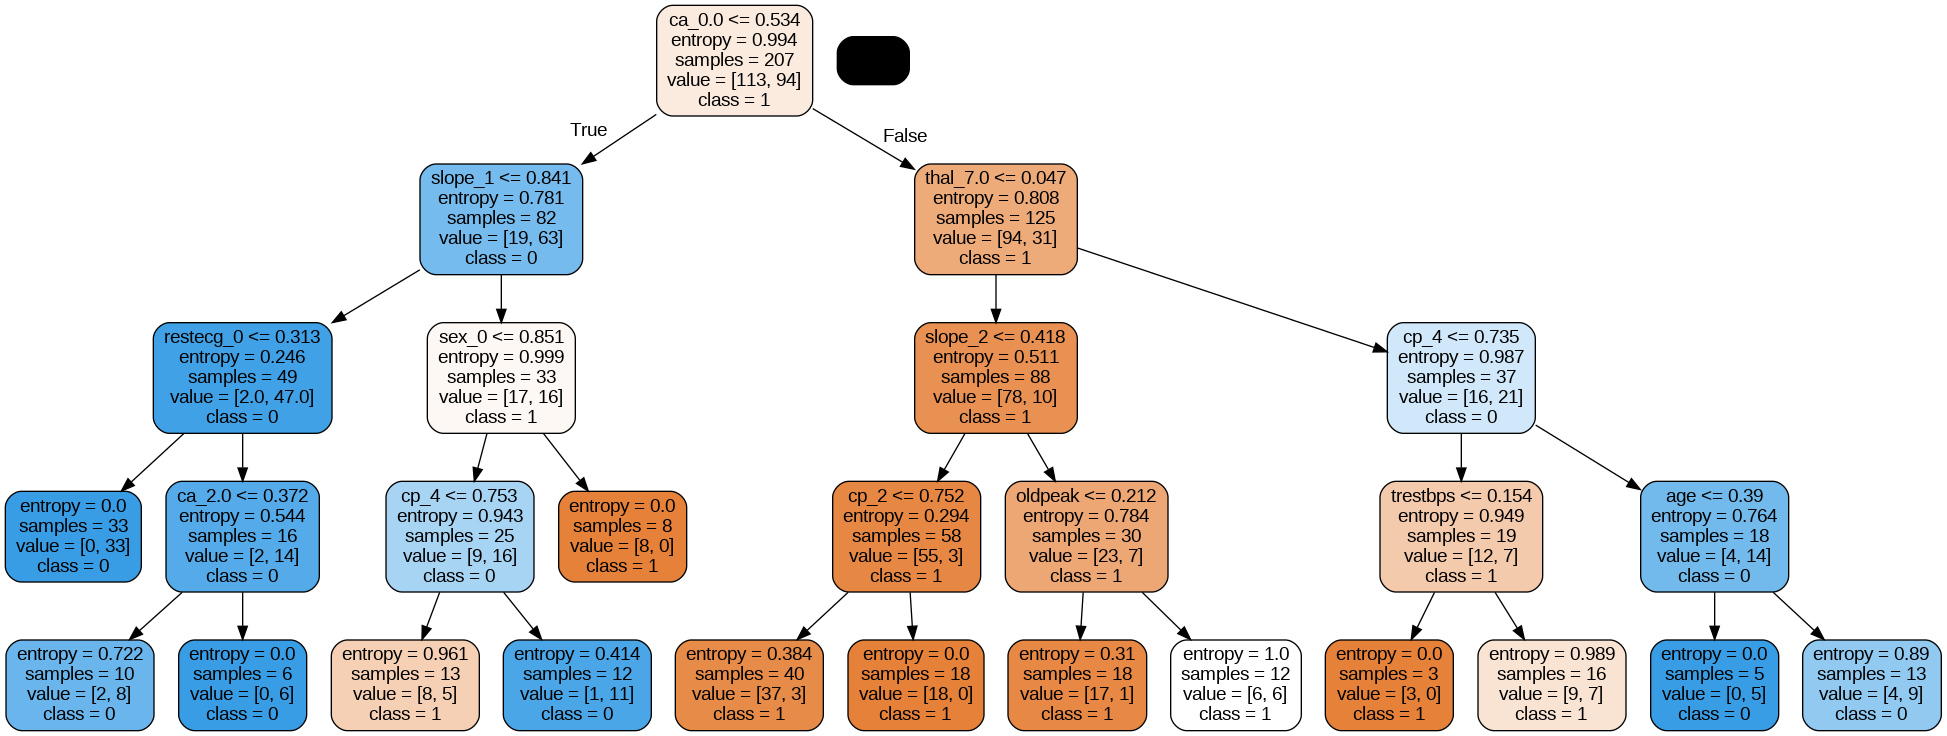

In [17]:
tree_dot = StringIO()

export_graphviz(
    tree_CV.best_estimator_,
    out_file = tree_dot,
    feature_names=X_train[int_names + dum_names].columns,
    class_names=y_train.astype(str).unique().tolist(),
    rounded=True,
    filled=True
)

tree_graph = pydotplus.graph_from_dot_data(tree_dot.getvalue())
Image(tree_graph.create_png())

In [18]:
feature_importances = tree_CV.best_estimator_.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train[int_names + dum_names].columns,
                              'Importance': feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
importance_df = importance_df.loc[importance_df['Importance'] > 0]
importance_df.index = np.arange(len(importance_df)) + 1
importance_df

,Feature,Importance
1,ca_0.0,0.3371
2,thal_7.0,0.1620
3,slope_1,0.1574
4,cp_4,0.0896
5,sex_0,0.0780
6,oldpeak,0.0492
7,slope_2,0.0365
8,restecg_0,0.0278
9,trestbps,0.0184
10,age,0.0181


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tree_train_pred = tree_CV.best_estimator_.predict(X_train[int_names + dum_names])
tree_test_pred = tree_CV.best_estimator_.predict(X_test[int_names + dum_names])

print("Classification Tree Summary:\n")

train_accuracy = accuracy_score(y_train, tree_train_pred)
test_accuracy = accuracy_score(y_test, tree_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

tree_cm = confusion_matrix(y_test, tree_test_pred)
tree_pcm = tree_cm.astype('float') / tree_cm.sum(axis=1)[:, np.newaxis]
tree_pcm = np.around(tree_pcm, decimals=4)

print("Confusion Matrix:\n", tree_cm)
print("Prop Conf Matrix:\n", tree_pcm)
print(classification_report(y_test, tree_test_pred))

Classification Tree Summary:

Training Accuracy: 0.8599
Test Accuracy: 0.8556
Confusion Matrix:
 [[41  6]
 [ 7 36]]
Prop Conf Matrix:
 [[0.8723 0.1277]
 [0.1628 0.8372]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.86      0.84      0.85        43

    accuracy                           0.86        90
   macro avg       0.86      0.85      0.86        90
weighted avg       0.86      0.86      0.86        90



### Summary

The features **ca, thal, slope, cp, sex, oldpeak, restecg, trestbps, and age** are the contributing predictors in a hyperparameter-tuned Classification Tree model. Using this model for feature selection, we accept these predictors and reject the following: **chol, thalach, fbs, and exang**.




In [20]:
int_names = ['age', 'trestbps', 'oldpeak']
cat_names = ['sex', 'cp', 'restecg', 'slope', 'thal', 'ca']
dum_names = ['sex_1', 'sex_0',
             'cp_4', 'cp_3', 'cp_2', 'cp_1',
             'restecg_0', 'restecg_2', 'restecg_1',
             'slope_1', 'slope_2', 'slope_3',
             'thal_3.0', 'thal_7.0', 'thal_6.0',
             'ca_0.0', 'ca_1.0', 'ca_2.0', 'ca_3.0']

X_train = Train[int_names + cat_names + dum_names]
X_test = Test[int_names + cat_names + dum_names]

## Segmentation Analysis

### K-Prototypes

In [21]:
# Install the kmodes package for K-prototypes
!pip install kmodes

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Adjust X_train and X_test to exclude dummy variables for K-prototypes
# Use only numerical and original categorical features
X_train_kp = Train[int_names + cat_names]
X_test_kp = Test[int_names + cat_names]
y_train = Train[tar_name]
y_test = Test[tar_name]

# Convert categorical variables to integer codes for K-prototypes
for col in cat_names:
    X_train_kp[col] = X_train_kp[col].cat.codes
    X_test_kp[col] = X_test_kp[col].cat.codes

# Define categorical feature indices (indices of cat_names in X_train_kp)
categorical_indices = [X_train_kp.columns.get_loc(col) for col in cat_names]

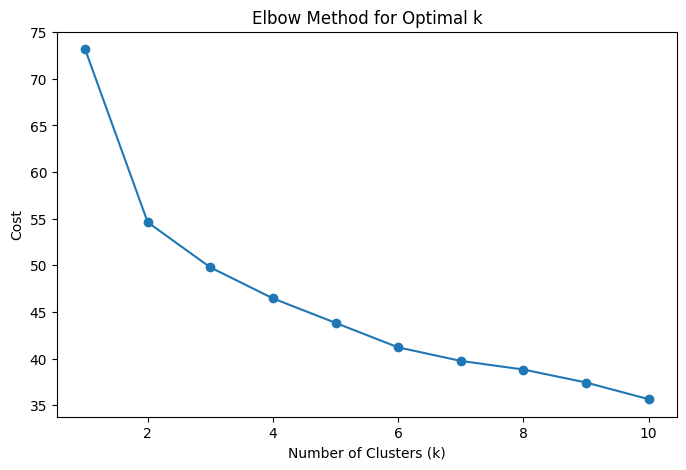

In [23]:
# **Step 1: Elbow Method to Select Number of Clusters (k)**
# Try k from 1 to 10 and plot the cost to find the elbow point
costs = []
k_values = range(1, 11)

for k in k_values:
    kp = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=0)
    kp.fit(X_train_kp.values, categorical=categorical_indices)
    costs.append(kp.cost_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [24]:
import pandas as pd
from kmodes.kprototypes import KPrototypes

# Set the optimal number of clusters
k_optimal = 3

# Dynamically determine categorical indices
categorical_indices = [X_train_kp.columns.get_loc(col) for col in cat_names]
print("Categorical indices:", categorical_indices)

# Verify data types
print("X_train_kp dtypes:")
print(X_train_kp.dtypes)

# Ensure categorical columns are integers
for col in cat_names:
    X_train_kp[col] = X_train_kp[col].astype('category').cat.codes
    X_test_kp[col] = X_test_kp[col].astype('category').cat.codes

# **Step 1: Fit K-prototypes Model**
kp = KPrototypes(n_clusters=k_optimal, init='Cao', n_init=10, verbose=2)
clusters_train = kp.fit_predict(X_train_kp.values, categorical=categorical_indices)

# Assign cluster labels to training data
Train['cluster'] = clusters_train

# Predict clusters for test data
clusters_test = kp.predict(X_test_kp.values, categorical=categorical_indices)
Test['cluster'] = clusters_test

# **Step 2: Interpretation of Clusters**
print("Type of cluster_centroids_:", type(kp.cluster_centroids_))
if isinstance(kp.cluster_centroids_, tuple):
    num_centroids = kp.cluster_centroids_[0]  # Numerical centroids
    cat_centroids = kp.cluster_centroids_[1]  # Categorical centroids
    print("Numerical centroids shape:", num_centroids.shape)
    print("Categorical centroids shape:", cat_centroids.shape)
else:
    print("Cluster centroids shape (single array):", kp.cluster_centroids_.shape)
    # If it's a single array, manually split based on numerical and categorical features
    n_numerical = len(int_names)
    num_centroids = kp.cluster_centroids_[:, :n_numerical]
    cat_centroids = kp.cluster_centroids_[:, n_numerical:]
    print("Adjusted numerical centroids shape:", num_centroids.shape)
    print("Adjusted categorical centroids shape:", cat_centroids.shape)

# Create DataFrame for numerical centroids
df = pd.DataFrame(num_centroids, columns=int_names)
print("Numerical Centroids (means for 'age', 'trestbps', 'oldpeak'):")
print(df)

# Create DataFrame for categorical centroids
print("\nCategorical Centroids (modes as codes for 'sex', 'cp', 'restecg', 'slope', 'thal'):")
print(pd.DataFrame(cat_centroids, columns=cat_names))

# Define mappings for categorical variables
sex_map = {0: 'female', 1: 'male'}
restecg_map = {0: 'normal', 1: 'ST-T wave abnormality', 2: 'left ventricular hypertrophy'}
slope_map = {0: 'upsloping', 1: 'flat', 2: 'downsloping'}
thal_map = {0: 'normal', 1: 'fixed defect', 2: 'reversible defect'}

# Convert categorical codes to human-readable categories
cat_centroids_df = pd.DataFrame({
    'sex': [sex_map.get(int(code), 'unknown') for code in cat_centroids[:, 0]],
    'restecg': [restecg_map.get(int(code), 'unknown') for code in cat_centroids[:, 1]],
    'slope': [slope_map.get(int(code), 'unknown') for code in cat_centroids[:, 2]],
    'thal': [thal_map.get(int(code), 'unknown') for code in cat_centroids[:, 3]]
})
print("\nCategorical Centroids (interpreted):")
print(cat_centroids_df)

# **Step 3: Evaluate Clustering**
# Analyze target distribution within clusters for training data
print("\nTarget Distribution within Clusters (Training Data):")
print(pd.crosstab(Train['cluster'], Train[tar_name], normalize='index'))

# Analyze target distribution within clusters for test data
print("\nTarget Distribution within Clusters (Test Data):")
print(pd.crosstab(Test['cluster'], Test[tar_name], normalize='index'))

Categorical indices: [3, 4, 5, 6, 7, 8]
X_train_kp dtypes:
age         float64
trestbps    float64
oldpeak     float64
sex            int8
cp             int8
restecg        int8
slope          int8
thal           int8
ca             int8
dtype: object
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 62, ncost: 53.0612603017937
Run: 1, iteration: 2/100, moves: 24, ncost: 52.51904797038446
Run: 1, iteration: 3/100, moves: 7, ncost: 52.37909137960395
Run: 1, iteration: 4/100, moves: 5, ncost: 52.23849597473726
Run: 1, iteration: 5/100, moves: 3, ncost: 52.21250855181538
Run: 1, iteration: 6/100, moves: 0, ncost: 52.21250855181538
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 60, ncost: 51.363426053047355
Run: 2, iteration: 2/100, moves: 34, ncost: 50.988614214379425
Run: 2, iteration:

In [25]:
# **Step 4: Prediction**
# Assign majority class from training clusters to test data
majority_class = Train.groupby('cluster')[tar_name].agg(lambda x: x.value_counts().idxmax())
Test['predicted'] = Test['cluster'].map(majority_class)

# **Step 5: Evaluation**
accuracy = accuracy_score(Test[tar_name], Test['predicted'])
conf_matrix = confusion_matrix(Test[tar_name], Test['predicted'])
class_report = classification_report(Test[tar_name], Test['predicted'])

print(f"\nAccuracy on Test Set: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy on Test Set: 0.8333

Confusion Matrix:
[[44  3]
 [12 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.85        47
           1       0.91      0.72      0.81        43

    accuracy                           0.83        90
   macro avg       0.85      0.83      0.83        90
weighted avg       0.85      0.83      0.83        90



In [26]:
c_train_K = clusters_train
c_test_K = clusters_test

### Gaussian Mixture Modeling

In [27]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [28]:
# Train-test split
X_train_GMM = Train[int_names + cat_names]
y_train_GMM = Train[tar_name]
X_test_GMM = Test[int_names + cat_names]
y_test_GMM = Test[tar_name]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_GMM)
X_test_scaled = scaler.transform(X_test_GMM)

In [29]:
# Fit Gaussian Mixture Model with 2 components
GMM = GaussianMixture(n_components=2, random_state=42)
GMM_model = GMM.fit(X_train_scaled)
print("Cluster Means:", GMM.means_)
print("Weights:", GMM.weights_) # Proportion of data points assigned to each cluster

Cluster Means: [[-0.28901877 -0.18692456 -0.34094253 -0.25136174 -0.49950893 -0.1426887
  -0.24759861 -0.65564016 -0.49387916]
 [ 0.36431893  0.23562538  0.42977077  0.31685084  0.62964962  0.17986443
   0.31210728  0.82645885  0.62255308]]
Weights: [0.55762729 0.44237271]


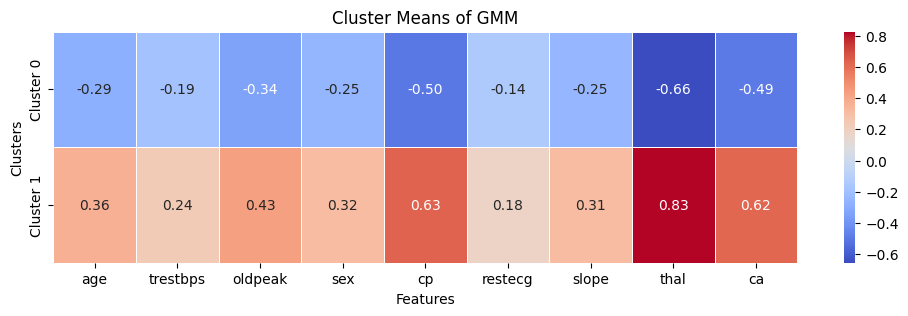

In [30]:
# Plot the heatmap of cluster means: to identify strong differentiating factors
X_train_GMM = X_train_GMM.drop(columns='Cluster', errors='ignore')

cluster_means = pd.DataFrame(GMM.means_, columns=X_train_GMM.columns)
cluster_means.index = [f'Cluster {i}' for i in range(GMM.n_components)]

plt.figure(figsize=(12, 3))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Cluster Means of GMM")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

**Interpretation**: Features with the most contrasting colors between clusters indicate strong differentiating factors. Thallium Stress Test and Chest Pain Type strongly separate clusters, for example.


In [31]:
# Predict the cluster for each data point
train_clusters = GMM.predict(X_train_scaled)
test_clusters = GMM.predict(X_test_scaled)

# Map clusters to labels based on majority class
# This maps clusters to the actual class labels as the cluster labels predicted in GMM (0 and 1) are arbitrary
def map_clusters_to_labels(y_true, clusters):
    from scipy.stats import mode
    labels = np.zeros_like(clusters) # Array of zeros with the same shape as clusters to store mapped labels
    for cluster in np.unique(clusters): # Loop through each unique cluster (0, 1)
        cluster_mask = clusters == cluster # Find the indices of samples in the current cluster (boolean array)
        if np.sum(cluster_mask) == 0:
          continue # Skip if no samples in this cluster
        majority_label = mode(y_true[cluster_mask], keepdims=True).mode[0] # Find the majority class for that cluster
        labels[cluster_mask] = majority_label # Assign the majority class to that cluster
    return labels

# Assign cluster labels based on majority class
train_pred_labels = map_clusters_to_labels(y_train.to_numpy(), train_clusters)
test_pred_labels = map_clusters_to_labels(y_test.to_numpy(), test_clusters)

<Figure size 800x500 with 0 Axes>

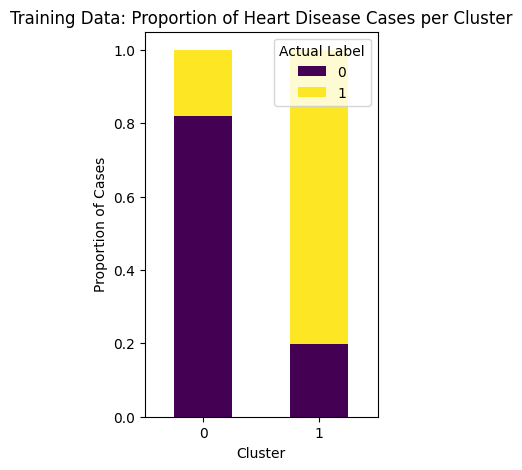

In [32]:
# Create bar graph comparing mapped clusters to actual disease labels.
train_comparison = pd.DataFrame({
    'Actual Label': y_train_GMM.to_numpy(),
    'Cluster': train_pred_labels
})

test_comparison = pd.DataFrame({
    'Actual Label': y_test_GMM.to_numpy(),
    'Cluster': test_pred_labels
})

# Count the distribution of actual labels within each cluster
train_cluster_distribution = train_comparison.groupby('Cluster')['Actual Label'].value_counts(normalize=True).unstack()
test_cluster_distribution = test_comparison.groupby('Cluster')['Actual Label'].value_counts(normalize=True).unstack()

# Plot training cluster distribution
plt.figure(figsize=(8, 5))
train_cluster_distribution.plot(kind='bar', stacked=True, colormap='viridis', figsize=(3, 5))
plt.title("Training Data: Proportion of Heart Disease Cases per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion of Cases")
plt.legend(title="Actual Label", loc="upper right")
plt.xticks(rotation=0)
plt.show()

<Figure size 500x500 with 0 Axes>

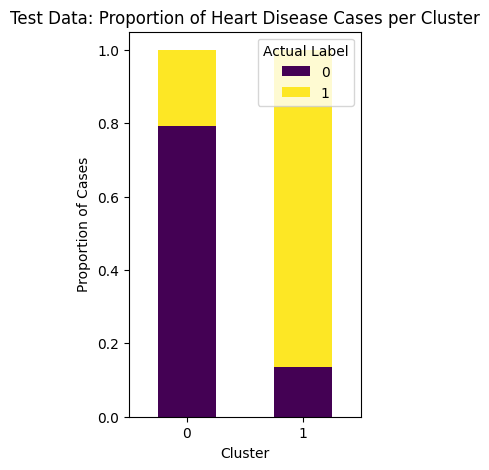

In [33]:
# Plot test cluster distribution
plt.figure(figsize=(5, 5))
test_cluster_distribution.plot(kind='bar', stacked=True, colormap='viridis', figsize=(3, 5))
plt.title("Test Data: Proportion of Heart Disease Cases per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion of Cases")
plt.legend(title="Actual Label", loc="upper right")
plt.xticks(rotation=0)
plt.show()

**Interpretation**: Cluster 0 has a higher proportion of non-disease cases (Label 0), and Cluster 1 has a higher proportion of disease cases (Label 1).
For both train and test data, about 80% of data points in each cluster are labeled correctly.

#### **GMM: Evaluation**

In [34]:
# Overall accuracy score
train_acc = accuracy_score(y_train, train_pred_labels)
test_acc = accuracy_score(y_test, test_pred_labels)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Training Accuracy: 0.81
Test Accuracy: 0.82


In [35]:
# Precision & Recall
report = classification_report(y_test_GMM.to_numpy(), test_pred_labels, target_names=['No Heart Disease', 'Heart Disease'])
print("\nClassification Report:\n", report)


Classification Report:
                   precision    recall  f1-score   support

No Heart Disease       0.79      0.89      0.84        47
   Heart Disease       0.86      0.74      0.80        43

        accuracy                           0.82        90
       macro avg       0.83      0.82      0.82        90
    weighted avg       0.83      0.82      0.82        90



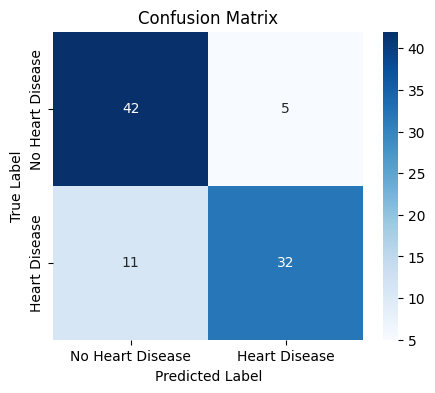

In [36]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test_GMM.to_numpy(), test_pred_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

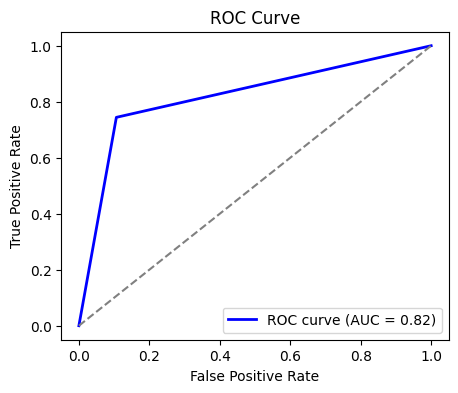

In [37]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_GMM.to_numpy(), test_pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate") # Healthy individuals (0) incorrectly classified as having heart disease
plt.ylabel("True Positive Rate") # Actual heart disease patients (1) correctly classified
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

**Interpretation:** The ROC curve shows that there is a trade-off between detecting true cases (high TPR) and avoiding false positives (low FPR). AUC = 0.82 indicates that the model is better than random guessing (Grey line = 0.5) at distinguishing between heart disease and non-heart disease cases.

In [38]:
c_train_G = train_clusters
c_test_G = test_clusters

### LCA

In [39]:
!pip install stepmix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.0 MB/s eta 0:00:00


In [40]:
from stepmix import StepMix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings

warnings.simplefilter("ignore", category=FutureWarning)

In [41]:
X_train_LCA = Train[int_names + cat_names]
X_test_LCA = Test[int_names + cat_names]
y_train_LCA = y_train
y_test_LCA = y_test

for var in int_names:
  X_train_LCA[var] = pd.qcut(X_train[var], q=3, labels=False, duplicates='drop')
  X_test_LCA[var] = pd.qcut(X_test[var], q=3, labels=False, duplicates='drop')

Fitting StepMix with 2 components...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:01<00:00, 39.39it/s, max_LL=5.11e+4, max_avg_LL=247]


AIC: -102145.31, BIC: -102081.98
Fitting StepMix with 3 components...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:00<00:00, 54.05it/s, max_LL=5.25e+4, max_avg_LL=254]


AIC: -104907.61, BIC: -104810.96
Fitting StepMix with 4 components...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:01<00:00, 48.90it/s, max_LL=5.36e+4, max_avg_LL=259]


AIC: -107100.90, BIC: -106970.92
Fitting StepMix with 5 components...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:01<00:00, 43.38it/s, max_LL=5.42e+4, max_avg_LL=262]


AIC: -108278.87, BIC: -108115.57
Fitting StepMix with 6 components...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:01<00:00, 32.35it/s, max_LL=5.48e+4, max_avg_LL=265]


AIC: -109402.36, BIC: -109205.73
Fitting StepMix with 7 components...
Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:02<00:00, 20.24it/s, max_LL=5.49e+4, max_avg_LL=265]


AIC: -109729.61, BIC: -109499.65


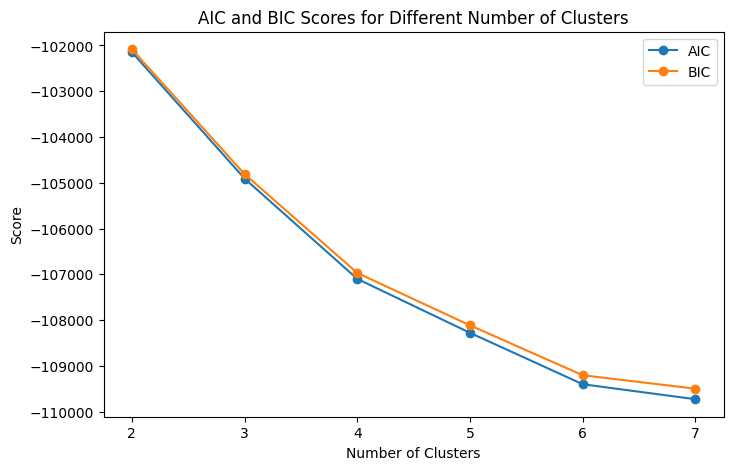

In [42]:
# Define the range of clusters you want to test
cluster_range = range(2, 8)  # testing models with 2 to 7 clusters
aic_scores = []
bic_scores = []

# Loop over the range of clusters
for n_components in cluster_range:
    print(f"Fitting StepMix with {n_components} components...")
    # Initialize the StepMix model
    model = StepMix(n_components=n_components, n_init=50, random_state=14)
    # Fit the model to your training data
    model.fit(X_train_LCA)

    # Retrieve AIC and BIC scores from the model
    aic = model.aic(X_train_LCA)
    bic = model.bic(X_train_LCA)
    print(f"AIC: {aic:.2f}, BIC: {bic:.2f}")

    # Append scores for later comparison
    aic_scores.append(aic)
    bic_scores.append(bic)

# Plot the AIC and BIC scores across the tested cluster numbers
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, aic_scores, marker='o', label='AIC')
plt.plot(cluster_range, bic_scores, marker='o', label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('AIC and BIC Scores for Different Number of Clusters')
plt.legend()
plt.show()

Since AIC nor BIC does not have a minimum (the scores keep decreasing as we increase the clusters), using the elbow method, 4 clusters is a good compromise to maximize interpretability and prevent overfitting.

In [43]:
# Define and fit the StepMix model with 4 clusters
model = StepMix(
    n_components=4,       # Number of latent classes
    measurement='categorical',
    structural='binary',
    n_steps=3,
    n_init=50,
    random_state=28
)

# Fit the model on training data, passing both X (features) and y (binary outcome)
model.fit(X_train_LCA, y_train)

# 1) Predict latent class memberships
train_clusters = model.predict(X_train_LCA)
test_clusters = model.predict(X_test_LCA)

# 2) Predict structural outcome (heart disease) using the structural model
train_predictions = model.predict_Y(X_train_LCA)
test_predictions = model.predict_Y(X_test_LCA)

# Evaluate performance on training set
print("\n")
print("\nTRAINING SET EVALUATION")
print("Accuracy:", accuracy_score(y_train, train_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, train_predictions))
print("\nClassification Report:\n", classification_report(y_train, train_predictions))

# Evaluate performance on test set
print("\nTEST SET EVALUATION")
print("Accuracy:", accuracy_score(y_test, test_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, test_predictions))
print("\nClassification Report:\n", classification_report(y_test, test_predictions))

# 3) (Optional) Add the predicted latent classes to your DataFrames
X_train_LCA['Latent Class'] = train_clusters
X_test_LCA['Latent Class'] = test_clusters

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:25<00:00,  1.95it/s, max_LL=-1.56e+3, max_avg_LL=-7.55]




TRAINING SET EVALUATION
Accuracy: 0.8019323671497585

Confusion Matrix:
 [[86 27]
 [14 80]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.81       113
           1       0.75      0.85      0.80        94

    accuracy                           0.80       207
   macro avg       0.80      0.81      0.80       207
weighted avg       0.81      0.80      0.80       207


TEST SET EVALUATION
Accuracy: 0.8

Confusion Matrix:
 [[36 11]
 [ 7 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80        47
           1       0.77      0.84      0.80        43

    accuracy                           0.80        90
   macro avg       0.80      0.80      0.80        90
weighted avg       0.80      0.80      0.80        90



In [44]:
marginal_distributions = {}

for col in X_train_LCA.columns:
    counts = X_train_LCA.groupby(['Latent Class', col])[col].count().unstack(fill_value=0)
    marginal_distributions[col] = counts.div(counts.sum(axis=1), axis=0)

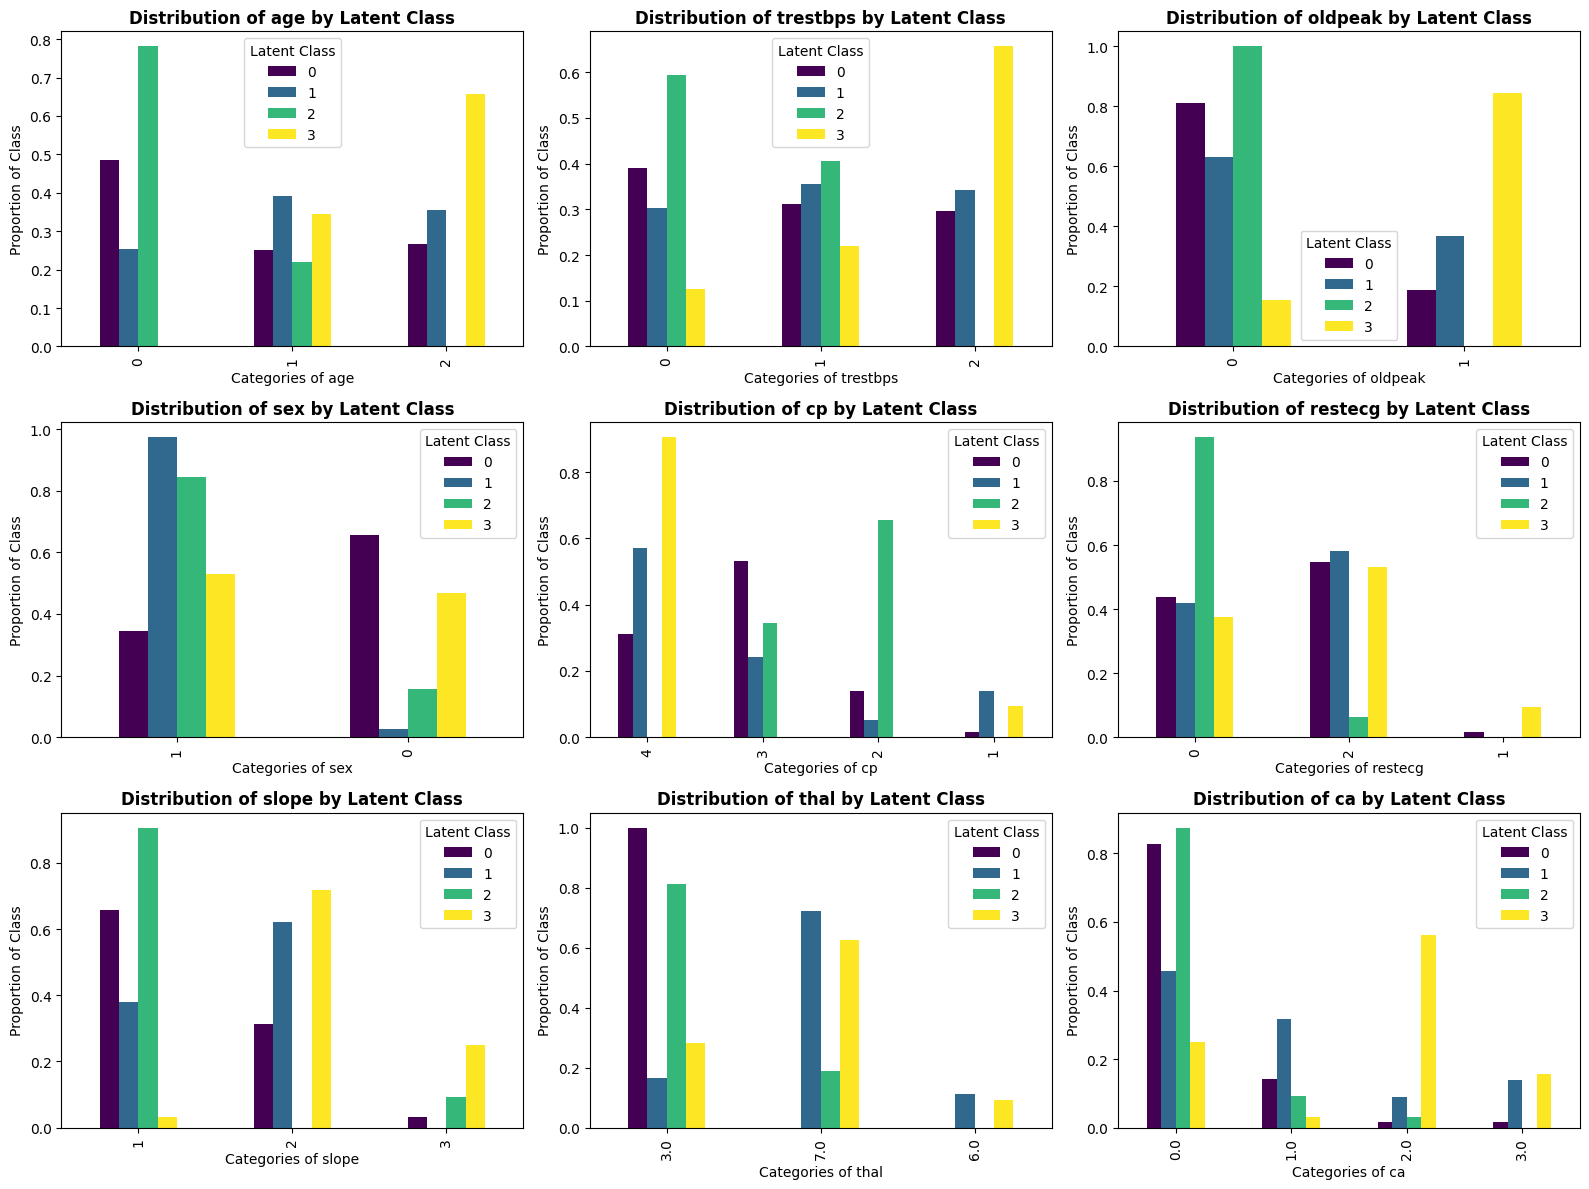

In [45]:
feature_cols = X_train_LCA.columns[:-1]

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
axs = axs.flatten()  # flatten to simplify indexing

for i, col in enumerate(feature_cols):
    ax = axs[i]
    marginal_distributions[col].T.plot(
        kind='bar',
        stacked=False,
        ax=ax,
        colormap='viridis'
    )
    ax.set_title(f'Distribution of {col} by Latent Class', fontweight="bold")
    ax.set_xlabel(f'Categories of {col}')
    ax.set_ylabel('Proportion of Class')

plt.tight_layout()
plt.show()

In [46]:
train_crosstab = pd.crosstab(X_train_LCA['Latent Class'], y_train)
train_proportions = train_crosstab.div(train_crosstab.sum(axis=1), axis=0)

test_crosstab = pd.crosstab(X_test_LCA['Latent Class'], y_test)
test_proportions = test_crosstab.div(test_crosstab.sum(axis=1), axis=0)

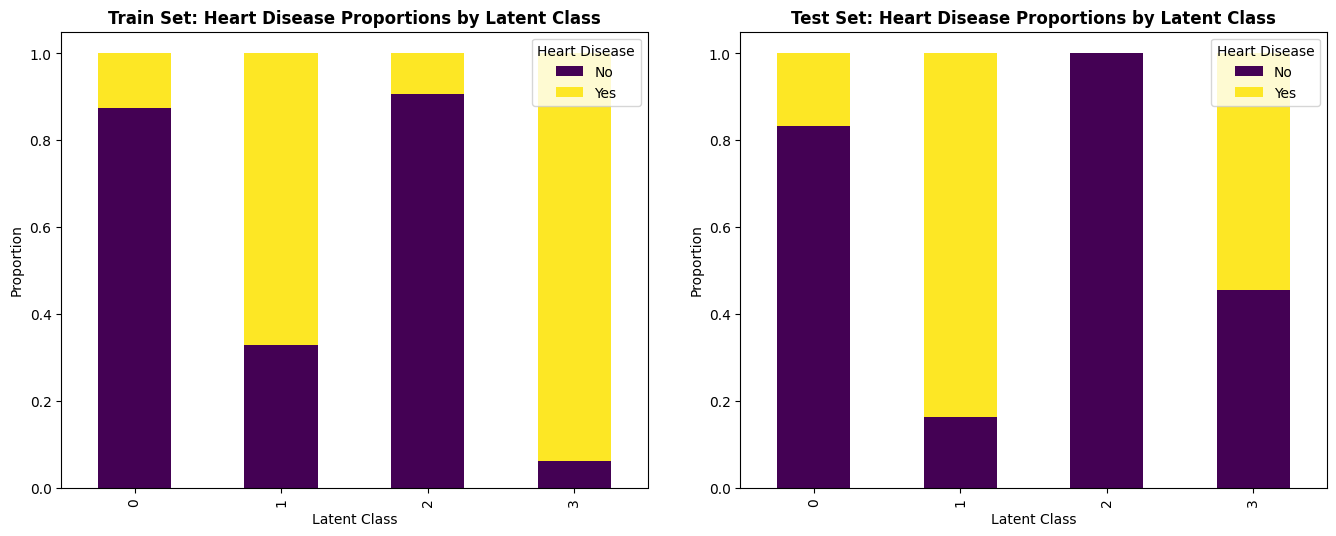

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the Train set
train_proportions.plot(kind='bar', stacked=True, ax=axs[0], colormap='viridis')
axs[0].set_title('Train Set: Heart Disease Proportions by Latent Class', fontweight="bold")
axs[0].set_xlabel('Latent Class')
axs[0].set_ylabel('Proportion')
# Adjust the legend labels if needed (assuming target values 0 and 1)
axs[0].legend(title='Heart Disease', labels=['No', 'Yes'])

# Plot for the Test set
test_proportions.plot(kind='bar', stacked=True, ax=axs[1], colormap='viridis')
axs[1].set_title('Test Set: Heart Disease Proportions by Latent Class', fontweight="bold")
axs[1].set_xlabel('Latent Class')
axs[1].set_ylabel('Proportion')
axs[1].legend(title='Heart Disease', labels=['No', 'Yes'])

# Adjust layout to add padding and avoid overlapping elements
plt.tight_layout(pad=3.0)
plt.show()

In [48]:
c_train_L = train_clusters
c_test_L = test_clusters

## Within-Cluster Predictive Model Considerations

Within-Cluster Prediction Functions

In [49]:
from sklearn.linear_model import LogisticRegression
# 2. Within-Cluster Logistic Regression
def within_cluster_logistic_regression(X_train, y_train, X_test, y_test, clusters_train, clusters_test):
    # Initialize dictionaries to store models and predictions
    cluster_models = {}
    train_predictions = np.zeros_like(y_train)
    test_predictions = np.zeros_like(y_test)
    train_probabilities = np.zeros_like(y_train, dtype=float)
    test_probabilities = np.zeros_like(y_test, dtype=float)
    cluster_train_probabilities = {}

    # Train logistic regression for each cluster
    for cluster in np.unique(clusters_train):
        # Get data for current cluster
        cluster_train_mask = clusters_train == cluster
        cluster_test_mask = clusters_test == cluster

        X_train_cluster = X_train[cluster_train_mask]
        y_train_cluster = y_train[cluster_train_mask]
        X_test_cluster = X_test[cluster_test_mask]
        y_test_cluster = y_test[cluster_test_mask]

        # Skip if cluster is empty
        if len(X_train_cluster) == 0:
            continue

        # Train logistic regression model
        lr_model = LogisticRegression(random_state=42, max_iter=1000)
        lr_model.fit(X_train_cluster, y_train_cluster)

        # Store model
        cluster_models[cluster] = lr_model

        # Predict for training and test sets
        train_predictions[cluster_train_mask] = lr_model.predict(X_train_cluster)
        test_predictions[cluster_test_mask] = lr_model.predict(X_test_cluster)

        # Store train probability estimates
        train_probabilities[cluster_train_mask] = lr_model.predict_proba(X_train_cluster)[:, 1]
        test_probabilities[cluster_test_mask] = lr_model.predict_proba(X_test_cluster)[:, 1]
        cluster_train_probabilities[cluster] = train_probabilities[cluster_train_mask]

    return cluster_models, train_predictions, test_predictions, train_probabilities, test_probabilities, cluster_train_probabilities

In [50]:
# 2. Within-Cluster Tree
def within_cluster_tree(X_train, y_train, X_test, y_test, clusters_train, clusters_test):
    # Initialize dictionaries to store models and predictions
    cluster_models = {}
    train_predictions = np.zeros_like(y_train)
    test_predictions = np.zeros_like(y_test)

    # Train logistic regression for each cluster
    for cluster in np.unique(clusters_train):
        # Get data for current cluster
        cluster_train_mask = clusters_train == cluster
        cluster_test_mask = clusters_test == cluster

        X_train_cluster = X_train[cluster_train_mask]
        y_train_cluster = y_train[cluster_train_mask]
        X_test_cluster = X_test[cluster_test_mask]
        y_test_cluster = y_test[cluster_test_mask]

        # Skip if cluster is empty
        if len(X_train_cluster) == 0:
            continue

        # Train tree model
        tree = DecisionTreeClassifier(criterion='entropy',
                                      max_depth=4,
                                      splitter='random',
                                      random_state=17)
        tree.fit(X_train_cluster, y_train_cluster)

        # Store model
        cluster_models[cluster] = tree

        # Predict for training and test sets
        train_predictions[cluster_train_mask] = tree.predict(X_train_cluster)
        test_predictions[cluster_test_mask] = tree.predict(X_test_cluster)

    return cluster_models, train_predictions, test_predictions

LCA

In [51]:
# 3. Hold-out Validation
cluster_models, train_pred, test_pred = within_cluster_tree(
    X_train[int_names + dum_names], y_train,
    X_test[int_names + dum_names], y_test,
    c_train_L, c_test_L
)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print("LCA Clusters\n=================================")

print("---------------------------------")
print("Classification Tree\n---------------------------------")
print("Hold-out Validation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred))

# 3. Hold-out Validation
cluster_models, train_pred, test_pred, train_prob, test_prob, c_train_probs = within_cluster_logistic_regression(
    X_train, y_train, X_test, y_test,
    c_train_L, c_test_L
)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print("---------------------------------")
print("Logistic Regression\n---------------------------------")
print("Hold-out Validation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred))

LCA Clusters
---------------------------------
Classification Tree
---------------------------------
Hold-out Validation Results:
Training Accuracy: 0.9179
Test Accuracy: 0.8222

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        47
           1       0.83      0.79      0.81        43

    accuracy                           0.82        90
   macro avg       0.82      0.82      0.82        90
weighted avg       0.82      0.82      0.82        90

---------------------------------
Logistic Regression
---------------------------------
Hold-out Validation Results:
Training Accuracy: 0.8889
Test Accuracy: 0.8111

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        47
           1       0.81      0.79      0.80        43

    accuracy                           0.81        90
   macro avg       0.81      0.81      0.8

GMM

In [52]:
# 3. Hold-out Validation
cluster_models, train_pred, test_pred = within_cluster_tree(
    X_train[int_names + dum_names], y_train,
    X_test[int_names + dum_names], y_test,
    c_train_G, c_test_G
)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print("GMM Clusters\n=================================")

print("---------------------------------")
print("Classification Tree\n---------------------------------")
print("Hold-out Validation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred))

# 3. Hold-out Validation
cluster_models, train_pred, test_pred, train_prob, test_prob, c_train_probs = within_cluster_logistic_regression(
    X_train, y_train, X_test, y_test,
    c_train_G, c_test_G
)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print("---------------------------------")
print("Logistic Regression\n---------------------------------")
print("Hold-out Validation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred))

## Adjust threshold for further improvements
thresholds = np.linspace(0.1, 0.9, 50)
accuracies = []

for threshold in thresholds:
    predictions = (train_prob >= threshold).astype(int)
    accuracies.append(accuracy_score(y_train, predictions))

best_threshold = thresholds[np.argmax(accuracies)]
thresh_preds_train = (train_prob >= best_threshold).astype(int)
thresh_preds_test = (test_prob >= best_threshold).astype(int)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, thresh_preds_train)
test_accuracy = accuracy_score(y_test, thresh_preds_test)

print("---------------------------------")
print("Logistic Regression with non-0.5 threshold\n---------------------------------")
print("Classification Threshold:", best_threshold)
print("Hold-out Validation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, thresh_preds_test))

GMM Clusters
---------------------------------
Classification Tree
---------------------------------
Hold-out Validation Results:
Training Accuracy: 0.9082
Test Accuracy: 0.7333

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        47
           1       0.79      0.60      0.68        43

    accuracy                           0.73        90
   macro avg       0.74      0.73      0.73        90
weighted avg       0.74      0.73      0.73        90

---------------------------------
Logistic Regression
---------------------------------
Hold-out Validation Results:
Training Accuracy: 0.8792
Test Accuracy: 0.8667

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        47
           1       0.90      0.81      0.85        43

    accuracy                           0.87        90
   macro avg       0.87      0.86      0.8

In [53]:
print("Relative Risk (RR) Analysis")
print("Heart Disease RR by Cluster")
print("*******************************")
clust1_avg_prob_HD = np.mean(c_train_probs[1])
clust0_avg_prob_HD = np.mean(c_train_probs[0])
relative_risk = clust1_avg_prob_HD / clust0_avg_prob_HD
print("LogReg Probabilities")
print(f"    RR in Cluster 1: {relative_risk:.4f}")
print(f"    RR in Cluster 0: {1/relative_risk:.4f}")
print(f"    P(HD|Cluster 1): {clust1_avg_prob_HD:.4f}")
print(f"    P(HD|Cluster 0): {clust0_avg_prob_HD:.4f}")
print("*******************************")
gclust1 = y_train[c_train_G == 1]
gclust0 = y_train[c_train_G == 0]
clust1_prop_HD = gclust1.value_counts()[1] / len(gclust1)
clust0_prop_HD = gclust0.value_counts()[1] / len(gclust0)
relative_risk0 = clust1_prop_HD / clust0_prop_HD
print("Frequentist Proportions")
print(f"    RR in Cluster 1: {relative_risk0:.4f}")
print(f"    RR in Cluster 0: {1/relative_risk0:.4f}")
print(f"    P(HD|Cluster 1): {clust1_prop_HD:.4f}")
print(f"    P(HD|Cluster 0): {clust0_prop_HD:.4f}")
print("*******************************")

Relative Risk (RR) Analysis
Heart Disease RR by Cluster
*******************************
LogReg Probabilities
    RR in Cluster 1: 4.4309
    RR in Cluster 0: 0.2257
    P(HD|Cluster 1): 0.8022
    P(HD|Cluster 0): 0.1810
*******************************
Frequentist Proportions
    RR in Cluster 1: 4.4312
    RR in Cluster 0: 0.2257
    P(HD|Cluster 1): 0.8022
    P(HD|Cluster 0): 0.1810
*******************************


K-Prototypes

In [54]:
# 3. Hold-out Validation
cluster_models, train_pred, test_pred = within_cluster_tree(
    X_train[int_names + dum_names], y_train,
    X_test[int_names + dum_names], y_test,
    c_train_K, c_test_K
)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print("K-Prototypes Clusters\n=================================")

print("---------------------------------")
print("Classification Tree\n---------------------------------")
print("Hold-out Validation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred))

# 3. Hold-out Validation
cluster_models, train_pred, test_pred, train_prob, test_prob, c_train_probs = within_cluster_logistic_regression(
    X_train, y_train, X_test, y_test,
    c_train_K, c_test_K
)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print("---------------------------------")
print("Logistic Regression\n---------------------------------")
print("Hold-out Validation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred))

K-Prototypes Clusters
---------------------------------
Classification Tree
---------------------------------
Hold-out Validation Results:
Training Accuracy: 0.8744
Test Accuracy: 0.7889

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        47
           1       0.83      0.70      0.76        43

    accuracy                           0.79        90
   macro avg       0.80      0.79      0.79        90
weighted avg       0.79      0.79      0.79        90

---------------------------------
Logistic Regression
---------------------------------
Hold-out Validation Results:
Training Accuracy: 0.8792
Test Accuracy: 0.8111

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        47
           1       0.81      0.79      0.80        43

    accuracy                           0.81        90
   macro avg       0.81      0.81

## Results

We choose Logistic Regression within GMM clusters as our final model. It boasts consistently high performance metrics in additional to being highly interpretable when it comes to predicting risk of heart disease.